### Imports

In [1]:
from __future__ import division
import itertools

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import math

from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

%matplotlib inline

### Wrangle

#### Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Parse Datetime

In [6]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)

In [7]:
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [8]:
df = df.set_index('timestamp')

#### Clean up text

In [9]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [10]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [11]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [13]:
df.request_agent.nunique()

9

### Detecting Anomalies in Discrete Variables

#### Finding anomalies in already existing data

In [16]:
# IP anomolies
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,35.175.171.137,2,0.000143
8,52.87.230.102,2,0.000143
9,35.174.209.2,1,0.000072
10,3.88.129.158,1,0.000072
11,95.31.16.121,1,0.000072
12,54.145.52.184,1,0.000072
13,97.105.15.120,1,0.000072


22
               ip  ip_count  ip_proba
12  54.145.52.184         1  0.000072
13  97.105.15.120         1  0.000072
14   52.91.30.150         1  0.000072
15  54.172.14.223         1  0.000072
16   45.23.250.16         1  0.000072
17  34.207.64.242         1  0.000072
18   95.31.18.119         1  0.000072
19  52.90.165.200         1  0.000072
20  34.229.70.250         1  0.000072
21   3.92.201.136         1  0.000072


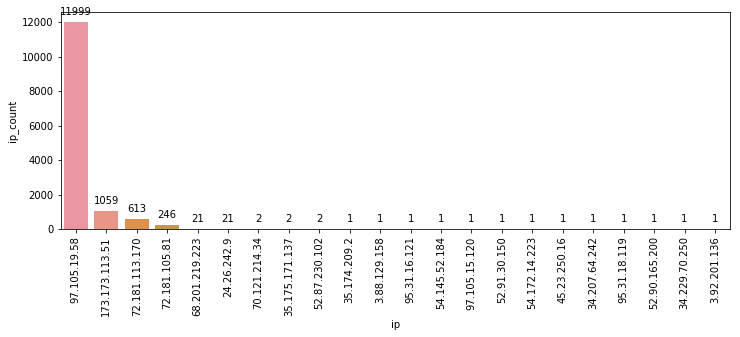

In [17]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

#### Add variable: converting bytes to mb

In [19]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

### Detecting anomalies by establishing a baseline and evaluate as new data arrives
#### Establish baseline

In [20]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

#### Compute probabilities based on train sample

In [21]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

#### Merge probabilities with all data (train + new data)
* Where the ip address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [22]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

### Conditional Probabilities: probabilities using 2 discrete variables
#### Probability of Destination given IP Address:
* If we are looking for an unexpected destinations (bad urls) from a known/common IP address.

In [23]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595


In [24]:
df.destination.value_counts(dropna=False)

0                                                               13953
https://python.zach.lol/                                            4
https://ds.codeup.com/8.3_Acquire/                                  3
https://python.zach.lol/api/v1/stores?page=1                        2
https://python.zach.lol/api/v1/                                     2
https://python.zach.lol/api/v1/items?page=0                         1
https://python.zach.lol/api/v1/helloclass!                          1
https://python.zach.lol/api/v1/stores?page=999                      1
https://python.zach.lol/api/v1/stores?page=2                        1
https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!                    1
https://python.zach.lol/api/v1//api/v1/items/next_page              1
http://localhost:8889/notebooks/timeseries_acquisition.ipynb        1
https://python.zach.lol/api/v1//api/v1/items                        1
https://python.zach.lol/api/v1/stores?page=0                        1
https://python.zach.

In [25]:
ip_probs = train.groupby('ip').size().div(len(df))

dest_given_ip = pd.DataFrame(train.groupby(['ip', 'destination']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_dest'})
                              )

In [28]:
ip_dest_count = pd.DataFrame(train.groupby(['ip', 'destination'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_dest_count'}))


ip_dest = dest_given_ip.merge(ip_dest_count)

#### Add these probabilities to original events to detect anomalous events

In [30]:
df = df.reset_index().merge(ip_dest, on=['ip', 'destination'], how='left').fillna(value=0).set_index('timestamp')

In [31]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_dest,ip_dest_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.0,0.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.0,0.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.0,0.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.0,0.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.0,0.0


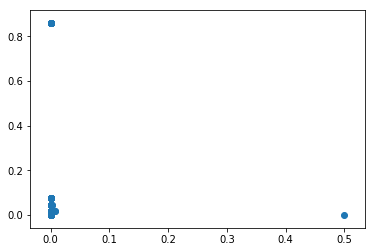

In [34]:
plt.scatter(df.proba_status_given_dest, df.ip_proba)

In [37]:
df[df.proba_status_given_dest >0]

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_dest,ip_dest_count
timestamp,,,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/V1/HiZach!,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
2019-04-16 19:44:04,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1/stores?page=0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
2019-04-16 19:44:16,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1/stores?page=1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000167,2.0
2019-04-16 19:44:24,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1/stores?page=1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000167,2.0
2019-04-16 19:44:28,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1/stores?page=2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
2019-04-16 19:44:38,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1/stores?page=999,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
2019-04-16 19:45:20,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1/items?page=0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
2019-04-16 19:49:41,97.105.19.58,GET /api/v1//api/v1/items HTTP/1.1,200,162,http://localhost:8889/notebooks/timeseries_acq...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
2019-04-16 19:49:43,97.105.19.58,GET /favicon.ico HTTP/1.1,200,162,https://python.zach.lol/api/v1//api/v1/items?p...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.858595,0.000083,1.0
